# Import Libraries

In [93]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [94]:
df = pd.read_csv('diabetes.csv')


# Replace outliers

In [95]:
def replace_outliers_with_nan(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df.loc[(df[feature] < lower_bound) | (df[feature] > upper_bound), feature] = np.nan
    
columns_to_check = ['preg', 'plas', 'pres', 'skin', 'insu', 'mass', 'pedi', 'age'] # numerical, derived from analyze_diabetes.ipynb

for column in columns_to_check:
    replace_outliers_with_nan(df, column)

# Replace Zeros with NaN and drop

In [96]:
columns_with_invalid_zeros = ['plas', 'pres', 'skin', 'insu', 'mass'] # as derived from analyze_diabetes.ipynb
df[columns_with_invalid_zeros] = df[columns_with_invalid_zeros].replace(0, np.nan)
df.dropna(inplace=True)

# Rank Features
Note: I did not figure out why using the the "chi2" method on non-categorical data, so I used both methods

In [97]:
df['class'] = df['class'].map({'tested_positive': 1, 'tested_negative': 0})
X = df.drop('class', axis=1)
y = df['class']

chi_scores = chi2(X, y)
chi2_df = pd.DataFrame(chi_scores[0], index=X.columns, columns=['Chi-squared Score'])
info_gain = mutual_info_classif(X, y)
info_gain_df = pd.DataFrame(info_gain, index=X.columns, columns=['Information Gain']).sort_values(by='Information Gain', ascending=False)

# Plotting
# Selecting discriminating (highest IG) and non-discriminating (lowest IG) feature
highest_IG_feature = info_gain_df.idxmax().values[0]
lowest_IG_feature = info_gain_df.idxmin().values[0]
highest_chi2_feature = chi2_df.idxmax().values[0]
lowest_chi2_feature = chi2_df.idxmin().values[0]

# Print highest/lowest

In [98]:
print("Hightest,Lowest mutual_info_classif Feature:",highest_IG_feature,lowest_IG_feature)
print("Hightest,Lowest chi2 Feature:",highest_chi2_feature,lowest_chi2_feature)

Hightest,Lowest mutual_info_classif Feature: plas skin
Hightest,Lowest chi2 Feature: insu pedi


# Boxplot and distribution plot of mutual_info_classif highest,lowest

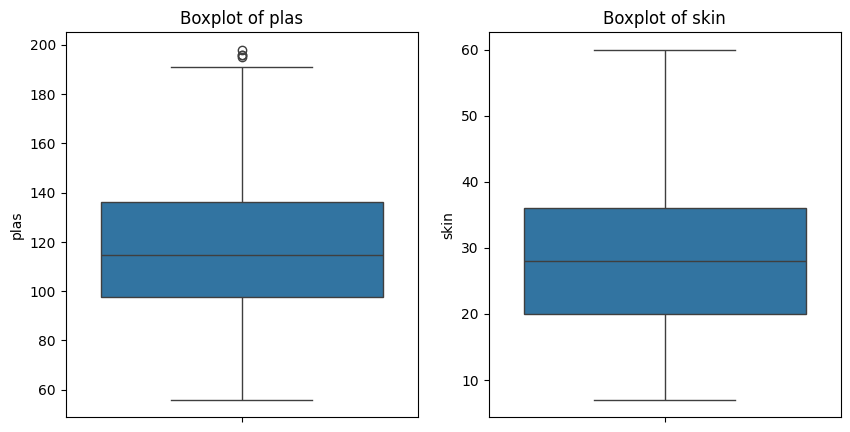

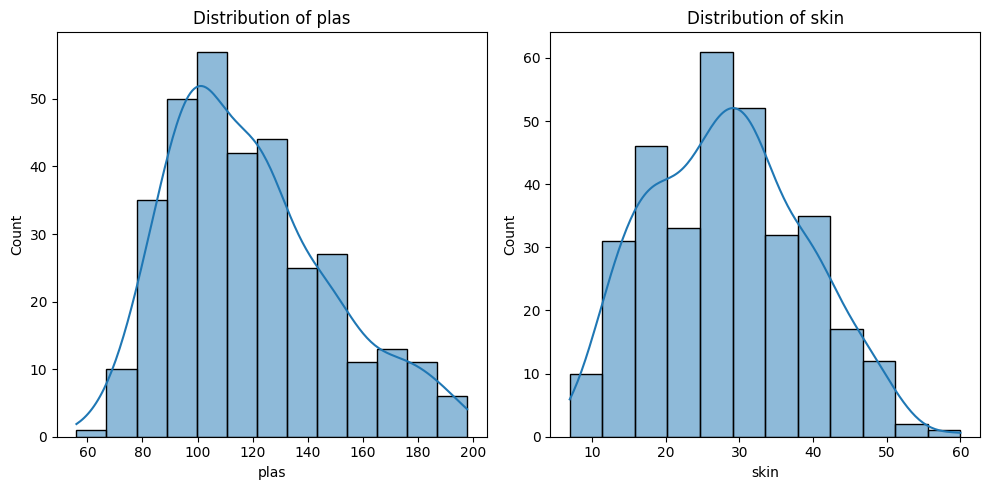

In [84]:
# Boxplot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df[highest_IG_feature])
plt.title(f'Boxplot of {highest_IG_feature}')

plt.subplot(1, 2, 2)
sns.boxplot(y=df[lowest_IG_feature])
plt.title(f'Boxplot of {lowest_IG_feature}')

# Distribution plots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(df[highest_IG_feature], kde=True)
plt.title(f'Distribution of {highest_IG_feature}')

plt.subplot(1, 2, 2)
sns.histplot(df[lowest_IG_feature], kde=True)
plt.title(f'Distribution of {lowest_IG_feature}')

plt.tight_layout()
plt.show()

# Boxplot and distribution plot of chi2 highest,lowest

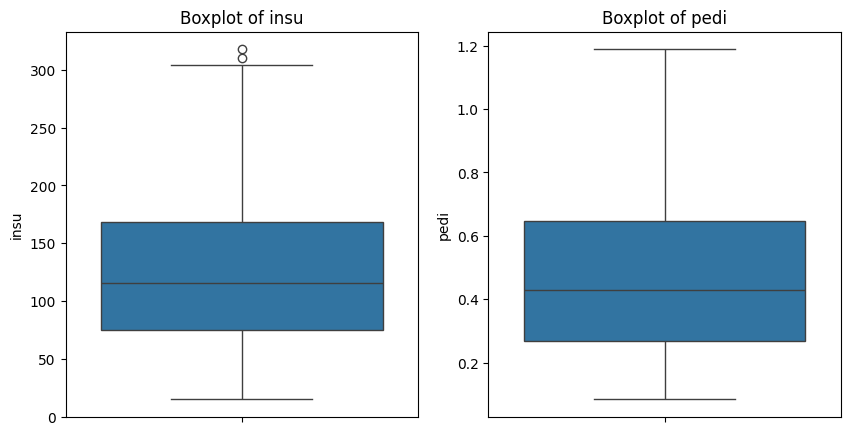

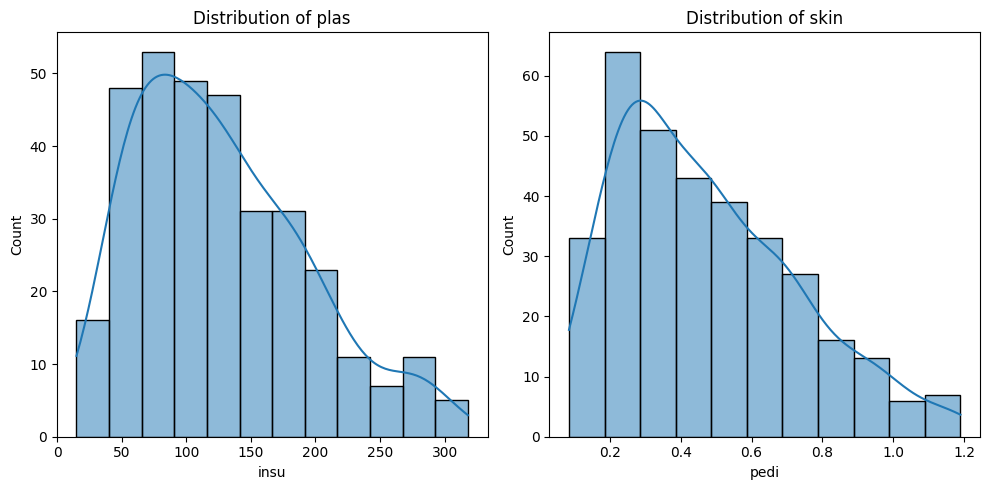

In [85]:
# Boxplot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df[highest_chi2_feature])
plt.title(f'Boxplot of {highest_chi2_feature}')

plt.subplot(1, 2, 2)
sns.boxplot(y=df[lowest_chi2_feature])
plt.title(f'Boxplot of {lowest_chi2_feature}')

# Distribution plots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(df[highest_chi2_feature], kde=True)
plt.title(f'Distribution of {highest_IG_feature}')

plt.subplot(1, 2, 2)
sns.histplot(df[lowest_chi2_feature], kde=True)
plt.title(f'Distribution of {lowest_IG_feature}')

plt.tight_layout()
plt.show()

# Create some models to evaluate the feature importance

For overview at first make a logistic regression, knowing that this is not the ideal model due to complex relationship and the usage of non-linear numeric variants


In [86]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Assuming `df` is your DataFrame after preprocessing
# Convert 'class' from categorical to numeric if it's not already numeric
df['class'] = df['class'].map({'tested_positive': 1, 'tested_negative': 0})

# Separate features and target variable
X = df.drop('class', axis=1)
y = df['class']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating the logistic regression model
model = LogisticRegression(max_iter=1000)

# Training the model
model.fit(X_train, y_train)

# Predicting the test set results
y_pred = model.predict(X_test)

# Evaluating the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# After training the model as previously described
feature_names = X.columns
coefficients = model.coef_[0]

# Create a DataFrame to view the feature names and their corresponding coefficients
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the features by their absolute coefficient values in descending order
feature_importance['Absolute Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Absolute Coefficient', ascending=False)

print(feature_importance[['Feature', 'Coefficient']])
coefficients = model.coef_[0]  # Get the coefficients for the features
odds_ratios = np.exp(coefficients)  # Calculate the odds ratios

# Displaying feature names alongside their odds ratios
feature_names = X_train.columns
odds_ratios_with_features = pd.DataFrame({'Feature': feature_names, 'Odds Ratio': odds_ratios})

# Sorting by odds ratios for interpretation
odds_ratios_with_features = odds_ratios_with_features.sort_values(by='Odds Ratio', ascending=False)

print(odds_ratios_with_features)

[[38  5]
 [15  9]]
              precision    recall  f1-score   support

           0       0.72      0.88      0.79        43
           1       0.64      0.38      0.47        24

    accuracy                           0.70        67
   macro avg       0.68      0.63      0.63        67
weighted avg       0.69      0.70      0.68        67

  Feature  Coefficient
6    pedi     0.731216
0    preg     0.052235
5    mass     0.047866
1    plas     0.039788
7     age     0.034895
3    skin     0.011782
4    insu     0.003193
2    pres     0.000752
  Feature  Odds Ratio
6    pedi    2.077606
0    preg    1.053624
5    mass    1.049030
1    plas    1.040590
7     age    1.035511
3    skin    1.011852
4    insu    1.003198
2    pres    1.000752



# Train a  DecisionTreeClassifier
                                                                                                                                     

In [87]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

decision_tree_model = DecisionTreeClassifier(random_state=42,max_depth=8)

decision_tree_model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=8, random_state=42)

# Plot Tree

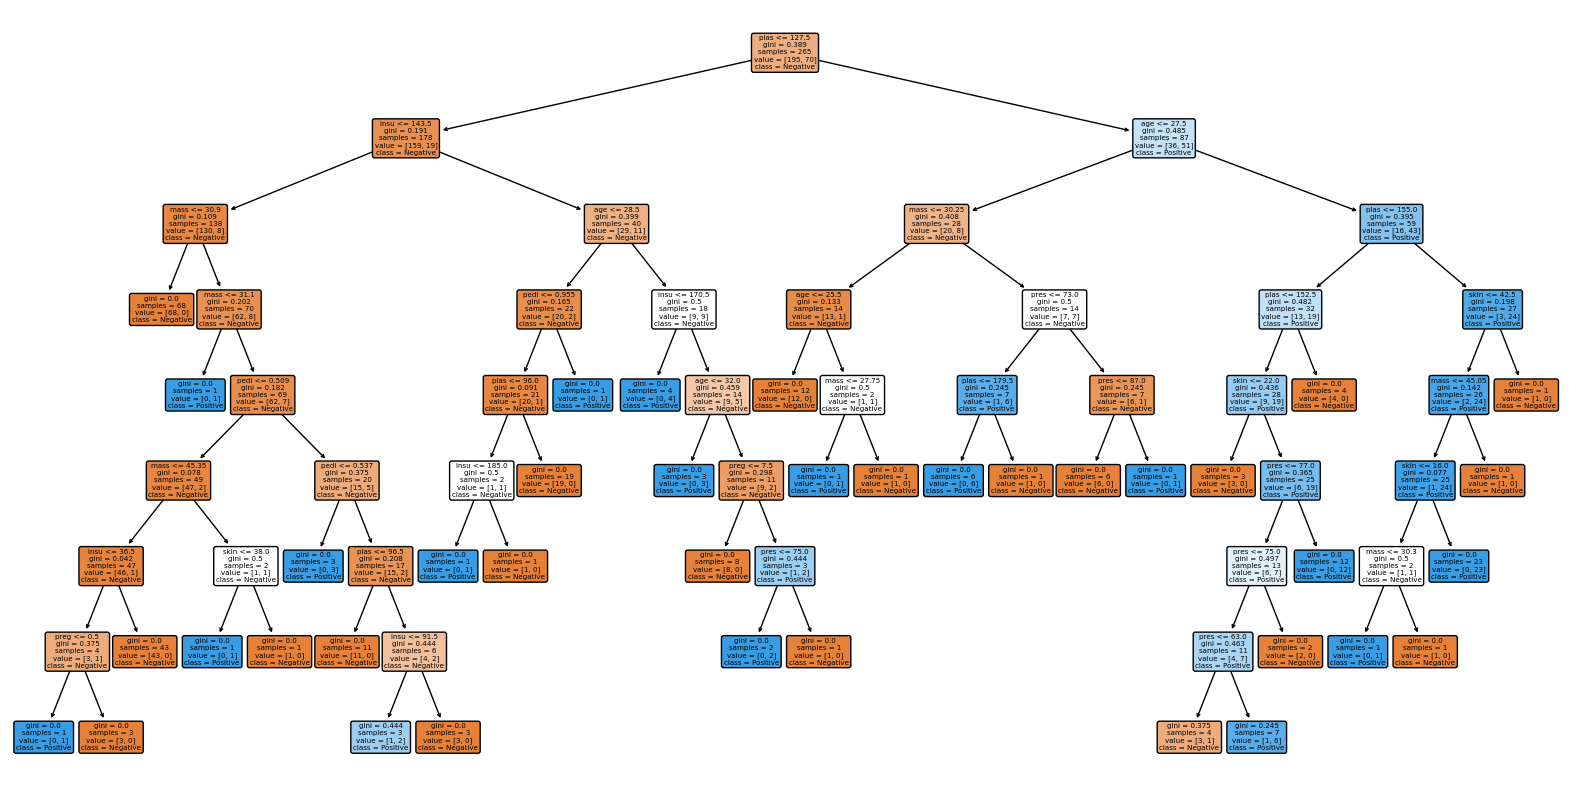

In [88]:
plt.figure(figsize=(20,10))
plot_tree(decision_tree_model, filled=True, rounded=True, class_names=['Negative', 'Positive'], feature_names=X_train.columns)
plt.show()

# Calculate and display Feature Importance

In [89]:

importances = decision_tree_model.feature_importances_
features_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
features_df = features_df.sort_values(by='Importance', ascending=False)
print(features_df)

  Feature  Importance
1    plas    0.366852
7     age    0.150124
2    pres    0.127192
5    mass    0.098666
4    insu    0.084122
6    pedi    0.070530
3    skin    0.067586
0    preg    0.034928


The result before was: 
 Hightest,Lowest mutual_info_classif Feature: plas skin
 Hightest,Lowest chi2 Feature: insu pedi

**The winner is: mutual_info_classif**


# Print DecisionTreeClassifier metrics

In [90]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = decision_tree_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])
print(report)

Accuracy: 0.7761
              precision    recall  f1-score   support

    Negative       0.80      0.86      0.83        43
    Positive       0.71      0.62      0.67        24

    accuracy                           0.78        67
   macro avg       0.76      0.74      0.75        67
weighted avg       0.77      0.78      0.77        67

